#### TENTATIVE UTLISATION DU TMJA dans le score

Notebook amorcé par : Jesshuan

Objectifs :

- à partir des fichiers geopandas "dataset_communes", "dataset_charge_points" et "TMJA2018" précedemment récupérés et complétés par l'équipe, évaluer la faisabilité et la pertinence des ompositions de sous-scores décrit dans les "Pistes de scores" (https://www.notion.so/dataforgood/New-Pistes-pour-le-score-1410a2aff0ee4b11b073b1850c87a95e) pour les sous-scores 1 et 2, qui font intervenir le TJMA "touristique", à savoir le TJMA de chaque route amputée de sa composante "locale".

- dans tous les cas, en profiter pour manier les alogorithmes de calcul type "plus proche route d'une commune", qui sera de toutes façons très certainement utilisé

Imports :

In [135]:
import geopandas as gpd
import geopy.distance
import os
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import copy
import requests
import io
import zipfile
import shutil

In [136]:
# data_path = 'C:/Users/demo/Desktop/Lattitude/datas/'
data_path = 'datas'
os.makedirs(data_path, exist_ok=True)

In [40]:
# OPTIONNAL : Import et test avec TMJA 2019, qui est un fichier plus incomplet (et routes encore plus discontinues...) que 2018

'''# tmja = gpd.read_file('C:/Users/demo/Desktop/Lattitude/datas/tmja2018-shp/TMJA2018.shp')
file_name = 'TMJA2019'
ext = '.shp'
url = 'https://static.data.gouv.fr/resources/trafic-moyen-journalier-annuel-sur-le-reseau-routier-national/20211222-170254/tmja2019-shp.zip'
temp_path = 'temp_unzip'

try: 
    tmja = gpd.read_feather(os.path.join(data_path,file_name + '.feather'))
except:
    # From url
    zip_file = requests.get(url).content
    os.makedirs(temp_path, exist_ok=True)
    with zipfile.ZipFile(io.BytesIO(zip_file)) as archive:
        archive.extractall(temp_path)
    tmja = gpd.read_file(os.path.join(temp_path,file_name + ext))
    shutil.rmtree(temp_path)

    # From local file
    # tmja = gpd.read_file(os.path.join(data_path,file_name + ext))

    # avoiding multi dowloads for GES emmision lowering
    tmja.to_feather(os.path.join(data_path,file_name + '.feather'))'''

"# tmja = gpd.read_file('C:/Users/demo/Desktop/Lattitude/datas/tmja2018-shp/TMJA2018.shp')\nfile_name = 'TMJA2019'\next = '.shp'\nurl = 'https://static.data.gouv.fr/resources/trafic-moyen-journalier-annuel-sur-le-reseau-routier-national/20211222-170254/tmja2019-shp.zip'\ntemp_path = 'temp_unzip'\n\ntry: \n    tmja = gpd.read_feather(os.path.join(data_path,file_name + '.feather'))\nexcept:\n    # From url\n    zip_file = requests.get(url).content\n    os.makedirs(temp_path, exist_ok=True)\n    with zipfile.ZipFile(io.BytesIO(zip_file)) as archive:\n        archive.extractall(temp_path)\n    tmja = gpd.read_file(os.path.join(temp_path,file_name + ext))\n    shutil.rmtree(temp_path)\n\n    # From local file\n    # tmja = gpd.read_file(os.path.join(data_path,file_name + ext))\n\n    # avoiding multi dowloads for GES emmision lowering\n    tmja.to_feather(os.path.join(data_path,file_name + '.feather'))"

In [137]:
# Load the data for French garge points
file_name = 'dataset_charge_points.feather'

bornes = gpd.read_feather(os.path.join(data_path, file_name))

# Load the data for the communes
file_name = 'dataset_communes.feather'

datas = gpd.read_feather(os.path.join(data_path, file_name))

file_name = 'TMJA2018'

tmja = gpd.read_feather(os.path.join(data_path,file_name + '.feather'))

--------

TESTS GENERAUX SUR LE FICHIER TJMA :

Le réseau routier national :

<Axes: >

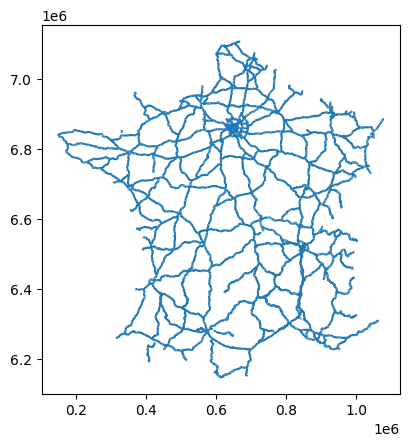

In [138]:
tmja.plot()

Conversion dans le système ws84 (coordonnées GPS standard) :

In [139]:
tmja_wrs84 = tmja.to_crs(4326)

In [140]:
len(tmja_wrs84)

5968

In [141]:
len(tmja_wrs84.loc[tmja_wrs84['tmja']==0,:])

1544

Beaucoup de traffic nul, cela doit être des données manquantes, plutôt...

In [142]:
fig = px.histogram(tmja_wrs84, 'tmja', nbins=300)
fig.show()

Effectivement ! Cela ressemble plutôt à des données manquantes.

Visulalisation des routes concernées :

<Axes: >

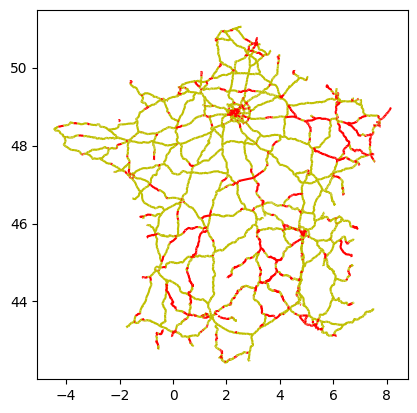

In [143]:
fig, ax = plt.subplots(1, 1)

tmja_wrs84.loc[tmja_wrs84['tmja']>0,:].plot(ax=ax, color='y')
tmja_wrs84.loc[tmja_wrs84['tmja']==0,:].plot(ax=ax, color='r')

Zoom autour des Bouches-du-Rhône :

In [144]:
to_keep = (tmja_wrs84['xD']>=850000) & (tmja_wrs84['xD']<=920000) & (tmja_wrs84['yD']<=6300000) & (tmja_wrs84['yD']>=6000000)

tmja_wrs84_dep13 = tmja_wrs84.loc[to_keep,:]

<Axes: >

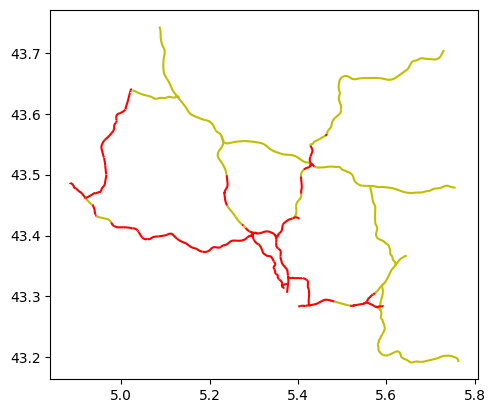

In [145]:
fig, ax = plt.subplots(1, 1)

tmja_wrs84_dep13.loc[tmja_wrs84_dep13['tmja']>0,:].plot(ax=ax, color='y')
tmja_wrs84_dep13.loc[tmja_wrs84_dep13['tmja']==0,:].plot(ax=ax, color='r')

Piste : Extrapolation du traffic possible par déduction via les plus proches voisines non nulles (de manière itérative)

La fonction ci-dessous extrapole le tmja des routes aux tmja nuls, grâce aux routes strictement adjacentes (point de départ = point d'arrivée de la route adjacente, point d'arrivée = point de départ de la route adjacente, point de départ = point de départ...) Une moyenne est faite parmi toutes les routes trouvées adjacentes (moyenne des routes à gauche et à droite, ou une seule route dans le cas d'une impasse, etc...)
Le processus est réitéré n fois (n défini à 30 ici), pour permettre le plus de complétion possibles (progression de proche en proche, dans le cas où plusieurs routes avec un tmja nulle se succède)


In [146]:
def split_and_fill_TMJA_null_values(df_tmja, nb_rep=10, buffer_size=0.01):

    geometry_conservation = df_tmja.geometry

    df_tmja_clean = copy.copy(df_tmja)

    try:
        df_tmja_clean.reset_index(names="road_index", inplace=True)
    except Exception as e:
        print(e)
        pass

    df_buf = df_tmja_clean.buffer(buffer_size)

    df_tmja_clean.geometry = df_buf

    total_values = 0

    for k in range(nb_rep):

        new_tmja = []
        values = 0

        tmja_list = df_tmja_clean['tmja'].to_list()
        index_list = df_tmja_clean['road_index'].to_list()

        df_join_road = df_tmja_clean.sjoin(df_tmja_clean, how='inner')
        df_join_road_clean = df_join_road.loc[df_join_road['road_index_left']!=df_join_road['road_index_right'],:]
        dict_new = df_join_road_clean[['road_index_left','tmja_right']].groupby('road_index_left').mean().to_dict()['tmja_right']

        for i, index in enumerate(index_list):
            old_tmja = tmja_list[i]
            if old_tmja == 0:
                try:
                    new_tmja.append(dict_new[index])
                    values+=1
                except:
                    new_tmja.append(old_tmja)
            else:
                new_tmja.append(old_tmja)
        
        df_tmja_clean['tmja'] = new_tmja
    
        total_values += values

        print(f'... {k+1} rounds done. {values} are been modified... Total values modified : {total_values}')
    
    df_tmja_clean.geometry = geometry_conservation

    return df_tmja_clean

In [147]:
tmja_wrs84_clean = split_and_fill_TMJA_null_values(tmja_wrs84, nb_rep=15)

/tmp/ipykernel_8881/1783197746.py:13: UserWarning:

Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




... 1 rounds done. 1543 are been modified... Total values modified : 1543
... 2 rounds done. 571 are been modified... Total values modified : 2114
... 3 rounds done. 312 are been modified... Total values modified : 2426
... 4 rounds done. 172 are been modified... Total values modified : 2598
... 5 rounds done. 87 are been modified... Total values modified : 2685
... 6 rounds done. 49 are been modified... Total values modified : 2734
... 7 rounds done. 29 are been modified... Total values modified : 2763
... 8 rounds done. 19 are been modified... Total values modified : 2782
... 9 rounds done. 17 are been modified... Total values modified : 2799
... 10 rounds done. 12 are been modified... Total values modified : 2811
... 11 rounds done. 7 are been modified... Total values modified : 2818
... 12 rounds done. 3 are been modified... Total values modified : 2821
... 13 rounds done. 1 are been modified... Total values modified : 2822
... 14 rounds done. 0 are been modified... Total values mo

Résultat (sur la distribution du tjma) :

In [148]:
fig = px.histogram(tmja_wrs84_clean, 'tmja', nbins=400)
fig.show()

<Axes: >

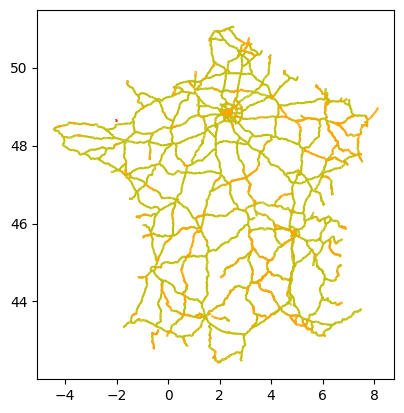

In [149]:
fig, ax = plt.subplots(1, 1)

tmja_wrs84.loc[tmja_wrs84_clean['tmja']>3000,:].plot(ax=ax, color='y')
tmja_wrs84.loc[(tmja_wrs84_clean['tmja']>0) & (tmja_wrs84['tmja']<3000),:].plot(ax=ax, color='orange')
tmja_wrs84.loc[tmja_wrs84_clean['tmja']==0,:].plot(ax=ax, color='r')


In [150]:
to_keep = (tmja_wrs84_clean['xD']>=850000) & (tmja_wrs84_clean['xD']<=920000) & (tmja_wrs84_clean['yD']<=6300000) & (tmja_wrs84_clean['yD']>=6000000)

tmja_wrs84_dep13_clean = tmja_wrs84_clean.loc[to_keep,:]

<Axes: >

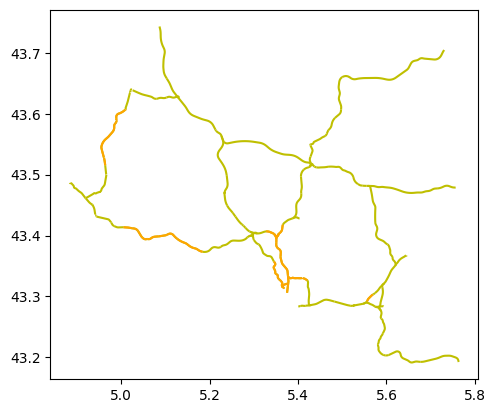

In [151]:
fig, ax = plt.subplots(1, 1)

tmja_wrs84_dep13_clean.loc[tmja_wrs84_dep13_clean['tmja']>0,:].plot(ax=ax, color='y')
tmja_wrs84_dep13_clean.loc[(tmja_wrs84_dep13_clean['tmja']>0) & (tmja_wrs84_dep13_clean['tmja']<3000),:].plot(ax=ax, color='orange')
#tmja_wrs84_dep13_clean.loc[tmja_wrs84_dep13_clean['tmja']==0,:].plot(ax=ax, color='r')

Problème en partie bien résolu... À voir la pertinence

-----

Extraction des éléments géométriques du fichier TMJA :

In [152]:
geo_list = tmja_wrs84_clean.geometry

TEST GENERAL DE RELEVES DES POINTS DE ROUTES :

On liste ici tous les points de toutes les routes (sous formes de liste de liste).
Dans la boucle, certaines routes posent problèmes : ce ne sont pas des LINESTRING mais des MULTIPLES STRINGS

In [153]:
lenght_geolist = len(geo_list)
problematic_roads = []
points_list = []

for i in range(lenght_geolist):
    try:
        points_list.append(list(geo_list[i].coords))
    except:
        problematic_roads.append(i)
        points_list.append([np.nan])

tmja_wrs84_clean['list_points'] = points_list

In [154]:
len(problematic_roads)

74

Exemple d'une route probématique :

In [155]:
tmja_wrs84.iloc[5747,:]

dateRefere                                           2018-01-01
route                                                     N0520
longueur                                                11981.0
prD                                                           5
depPrD                                                       87
concession                                                    N
absD                                                      560.0
cumulD                                                   5560.0
xD                                                    562481.51
yD                                                   6535034.52
zD                                                          0.0
prF                                                          19
depPrF                                                       87
concessi_1                                                    N
absF                                                      540.0
cumulF                                  

Les routes problématiques sont les routes qui sont, visiblement, des MULTILINESSTRING.... Illustration en image :

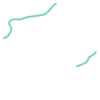

In [156]:
tmja_wrs84.geometry.to_list()[5747]

Ce sont des routes discontinues, très probablement des routes nationales (non autoroutes)

On récupère aussi les centres de routes :

In [157]:
tmja_wrs84_clean['Road_center'] = tmja_wrs84_clean.to_crs('+proj=cea').geometry.centroid.to_crs(tmja_wrs84.crs)

In [158]:
tmja_wrs84

,dateRefere,route,longueur,prD,depPrD,concession,absD,cumulD,xD,yD,...,cumulF,xF,yF,zF,cote,anneeMesur,typeCompta,tmja,pctPL,geometry
0,2018-01-01,69D0301,6055.0,2,69,N,-981.0,0.0,844036.84,6510806.45,...,6055.0,849346.89,6509342.34,0.0,I,0,None,0,0.0,"LINESTRING (4.85057 45.68163, 4.85068 45.68180..."
1,2018-01-01,69D0383,13752.0,4,69,N,-494.0,0.0,846831.30,6522372.16,...,13752.0,843537.87,6512429.80,0.0,I,0,None,0,0.0,"LINESTRING (4.89002 45.78515, 4.89044 45.78476..."
2,2018-01-01,69D0383BPNL,2408.0,0,69,N,0.0,0.0,844982.46,6522772.27,...,2408.0,846831.30,6522372.16,0.0,I,0,None,0,0.0,"LINESTRING (4.86635 45.78915, 4.86652 45.78922..."
3,2018-01-01,75000C01,35040.0,0,75,N,0.0,0.0,655221.44,6858722.80,...,35040.0,655221.44,6858722.80,0.0,I,0,None,0,0.0,"LINESTRING (2.28085 48.87830, 2.28107 48.87860..."
4,2018-01-01,75000C02,35040.0,0,75,N,0.0,0.0,655227.28,6858703.75,...,35040.0,655227.28,6858703.75,0.0,I,0,None,0,0.0,"LINESTRING (2.28063 48.87837, 2.28082 48.87862..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5963,2018-01-01,N1547,2687.0,6,13,N,0.0,0.0,895516.86,6250912.48,...,2687.0,892891.80,6250945.63,0.0,I,2018,8,0,0.0,"LINESTRING (5.40975 43.33051, 5.40962 43.33043..."
5964,2018-01-01,P0224,8995.0,211,31,N,-638.0,0.0,555988.61,6288880.30,...,8995.0,562812.02,6287175.90,0.0,I,0,None,0,0.0,"LINESTRING (1.21422 43.68430, 1.21448 43.68436..."
5965,2018-01-01,P0524,1777.0,31,33,N,-768.0,0.0,440252.10,6361052.92,...,1777.0,440343.36,6359374.43,0.0,I,0,None,0,0.0,"LINESTRING (-0.25658 44.30029, -0.25652 44.300..."
5966,2018-01-01,P0524,3860.0,31,33,N,1009.0,1777.0,458798.85,6325912.32,...,5637.0,458785.94,6322872.51,0.0,I,0,None,0,0.0,"LINESTRING (-0.00751 43.99087, -0.00751 43.990..."


---------

Données des communes :

In [159]:
datas[['nb_vp', 'nb_vp_rechargeables_gaz', 'nb_vp_rechargeables_el']].describe()

,nb_vp,nb_vp_rechargeables_gaz,nb_vp_rechargeables_el
count,314535.000000,314535.000000,314535.000000
mean,1863.089103,0.119955,19.333298
std,7242.008462,2.711924,103.856129
min,1.000000,0.000000,0.000000
25%,236.000000,0.000000,1.000000
50%,522.000000,0.000000,3.000000
75%,1285.000000,0.000000,10.000000
max,405637.000000,371.000000,6156.000000


In [160]:
datas.head()

,insee,nom,wikipedia,surf_ha,geometry,PMUN,PCAP,PTOT,nb_vp,libepci,libgeo,nb_vp_rechargeables_gaz,date_arrete,epci,nb_vp_rechargeables_el,dep,dep_name,region_name
0,2B222,Pie-d'Orezza,fr:Pie-d'Orezza,573.0,"POLYGON ((9.32017 42.38507, 9.32028 42.38510, ...",37.0,0.0,37.0,33.0,CC de la Castagniccia-Casinca,PIE-D'OREZZA,0.0,2021-03-31,200073252,0.0,2B,Haute-Corse,Corse
0,2B222,Pie-d'Orezza,fr:Pie-d'Orezza,573.0,"POLYGON ((9.32017 42.38507, 9.32028 42.38510, ...",37.0,0.0,37.0,32.0,CC de la Castagniccia-Casinca,PIE-D'OREZZA,0.0,2021-09-30,200073252,0.0,2B,Haute-Corse,Corse
0,2B222,Pie-d'Orezza,fr:Pie-d'Orezza,573.0,"POLYGON ((9.32017 42.38507, 9.32028 42.38510, ...",37.0,0.0,37.0,32.0,CC de la Castagniccia-Casinca,PIE-D'OREZZA,0.0,2021-06-30,200073252,0.0,2B,Haute-Corse,Corse
0,2B222,Pie-d'Orezza,fr:Pie-d'Orezza,573.0,"POLYGON ((9.32017 42.38507, 9.32028 42.38510, ...",37.0,0.0,37.0,32.0,CC de la Castagniccia-Casinca,PIE-D'OREZZA,0.0,2021-12-31,200073252,0.0,2B,Haute-Corse,Corse
0,2B222,Pie-d'Orezza,fr:Pie-d'Orezza,573.0,"POLYGON ((9.32017 42.38507, 9.32028 42.38510, ...",37.0,0.0,37.0,32.0,CC de la Castagniccia-Casinca,PIE-D'OREZZA,0.0,2022-06-30,200073252,0.0,2B,Haute-Corse,Corse


Les lignes des données de communes sont redondantes, car les données d'enregistrement des véhicules sont trimestriels. On récupère donc ici seulement les données les plus actuelles :

In [161]:
communes_fin_2022 = datas.loc[datas['date_arrete']=='2022-12-31']

Petite visualisation du ratio des enregistrements de VE au passage :

In [162]:
communes_fin_2022[['nb_vp', 'nb_vp_rechargeables_gaz', 'nb_vp_rechargeables_el']].sum()

nb_vp                      65944969.0
nb_vp_rechargeables_gaz        4562.0
nb_vp_rechargeables_el       992737.0
dtype: float64

On ne va garder que les communes en métropole :

In [163]:
extra_metropole = [code_insee for code_insee in communes_fin_2022['insee'].to_list() if code_insee[0:2]=='2A' or code_insee[0:2]=='2B' or code_insee[0:2]=='97' or code_insee[0:2]=='98']

In [164]:
communes_metropole = communes_fin_2022.loc[~communes_fin_2022['insee'].isin(extra_metropole),:]

On ajoute une colonne au dataframe pour accéder directement au centre de la commune :

In [165]:
communes_metropole['coords_centre'] = communes_metropole.to_crs('+proj=cea').geometry.centroid.to_crs(communes_metropole.crs)

/home/jesshuan/miniconda3/envs/ECartoMobile/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Affichage simultannée des communes de France métropolitaine et du réseau de routes nationales :

<Axes: >

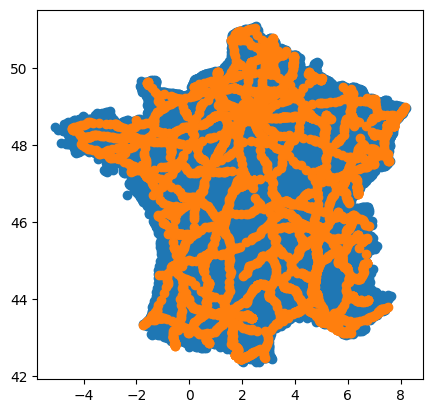

In [166]:
fig, ax = plt.subplots(1, 1)

communes_metropole['coords_centre'].plot(ax=ax)
tmja_wrs84_clean['Road_center'].plot(ax=ax)


-----------

TENTATIVE DE DISSOCIATION DU TMJA EN TJMA GLOBAL ET TJMA TOURSTIQUE :

Test effectué sur le département des Bouches-du-Rhône, pour réduire le (long !) temps de calcul...

In [167]:
dep_13 = [code_insee for code_insee in communes_metropole['insee'].to_list() if code_insee[0:2]=='13']

In [168]:
communes_bdr_13 = communes_metropole.loc[communes_metropole['insee'].isin(dep_13),:]

In [169]:
communes_bdr_13.head()

,insee,nom,wikipedia,surf_ha,geometry,PMUN,PCAP,PTOT,nb_vp,libepci,libgeo,nb_vp_rechargeables_gaz,date_arrete,epci,nb_vp_rechargeables_el,dep,dep_name,region_name,coords_centre
13685,13107,Simiane-Collongue,fr:Simiane-Collongue,3004.0,"POLYGON ((5.39283 43.41646, 5.39400 43.41687, ...",5596.0,91.0,5687.0,6793.0,Métropole d'Aix-Marseille-Provence,SIMIANE-COLLONGUE,0.0,2022-12-31,200054807,177.0,13,Bouches-du-Rhône,Provence-Alpes-Côte d'Azur,POINT (5.43758 43.41151)
13686,13001,Aix-en-Provence,fr:Aix-en-Provence,18748.0,"POLYGON ((5.26947 43.49617, 5.26965 43.49648, ...",142482.0,3194.0,145676.0,154907.0,Métropole d'Aix-Marseille-Provence,AIX-EN-PROVENCE,132.0,2022-12-31,200054807,4284.0,13,Bouches-du-Rhône,Provence-Alpes-Côte d'Azur,POINT (5.39858 43.53607)
13687,13080,Le Puy-Sainte-Réparade,fr:Le Puy-Sainte-Réparade,4487.0,"POLYGON ((5.39213 43.64983, 5.39638 43.65622, ...",5719.0,92.0,5811.0,6797.0,Métropole d'Aix-Marseille-Provence,LE PUY-SAINTE-RÉPARADE,0.0,2022-12-31,200054807,184.0,13,Bouches-du-Rhône,Provence-Alpes-Côte d'Azur,POINT (5.43965 43.65158)
13905,13055,Marseille,fr:Marseille,24214.0,"MULTIPOLYGON (((5.22863 43.19774, 5.22866 43.1...",NaN,NaN,NaN,72.0,Métropole d'Aix-Marseille-Provence,MARSEILLE ND,0.0,2022-12-31,200054807,0.0,13,Bouches-du-Rhône,Provence-Alpes-Côte d'Azur,POINT (5.41910 43.29233)
13933,13064,Mollégès,fr:Mollégès,1426.0,"POLYGON ((4.90858 43.81207, 4.91584 43.81248, ...",2594.0,28.0,2622.0,2925.0,CA Terre de Provence,MOLLÉGÈS,0.0,2022-12-31,200035087,69.0,13,Bouches-du-Rhône,Provence-Alpes-Côte d'Azur,POINT (4.94933 43.80512)


In [132]:
#communes_bdr_13[['nom', 'surf_ha', 'nb_vp', 'nb_vp_rechargeables_gaz', 'nb_vp_rechargeables_el']].to_csv('./datas/communes_vp_ve__dep_13.csv')

Définition du périmètre de sélection initial (pour limiter les calculs) : un cercle de grand rayon (70 km à vol d'oiseau) en s'assurant que toute commune possède bien au moins une route dans ce rayon, dans la France entière.
Pour chaque commune, on va d'abord dresser la liste de toutes les routes éligibles (selon distance à vol d'oiseau) dans ce rayon, avant de passer à un calcul plus précis...

In [170]:
DIST_VOL_OISEAU = 70000 # meters

In [133]:
nearlier_road = []
nearlier_road_dist = []
multiline_road = []
problematic_road = []

for k, coord_center in enumerate(communes_bdr_13['coords_centre'].geometry): # pour chaque commune (centre de commune)

    list_index_nearly = []
    list_coord_nearly = []
    list_dist = []


    # ETAPE 1 - SELECTION "À LA LOUCHE" DES ROUTES DANS LE BON RAYON LARGE

    for i, road_center in enumerate(tmja_wrs84_clean['Road_center'].geometry): # pour chaque route du fichier

        dist_oiseau = geopy.distance.geodesic(coord_center.coords, road_center.coords).meters #
        if dist_oiseau<=DIST_VOL_OISEAU: # on ne garde la route que si elle est incluse dans le périmètre défini
            list_index_nearly.append(i)
            try:
                # Ajout de toutes les coordonnées de tous les points de la route dans la liste :
                list_coord_nearly.append([tupple_coord for tupple_coord in tmja_wrs84.geometry.to_list()[i].coords])
            except:
                try:
                    # En cas de MultiStrings (routes discontinues)...
                    # À défaut, ajout de toutes les coordonnées de tous les points de la route dans la liste, en cassant différemment le format :
                    list_coord_nearly.append([tupple for linestring in tmja_wrs84.geometry[i].geoms for tupple in linestring.coords])
                    multiline_road.append(tmja_wrs84_clean.iloc[i, 1])
                except:
                    # En cas de nouveau problème...
                    # On enregistre seulement le centre de la route... (dommage)
                    # On enregistre l'index de la route problématique
                    list_coord_nearly.append([road_center.coords])
                    problematic_road.append(tmja_wrs84_clean.iloc[i, 1])

    
    # ETAPE 2 - CALCUL DE DISTANCE À CHAQUE POINT ROUTE

    # ICI, REMPLACER PAR CALCUL API DE DISTANCE TEMPORELLE ROUTIERE :
    # BOUCLE AVEC REQUETES À L'API POUR EVALUATION DU TEMPS ROUTIER DU POINT COMMUNE/CENTRE-VILLAGE
    # À CHAQUE POINT DE ROUTE DE LA LISTE
    #for coord_road in list_coord_nearly:
        # ...
        # best_dist =
        # best_index = 

    # SOLUTION DE REMPLACEMENT (VOL D'OISEAU) :

    dist_minimal = DIST_VOL_OISEAU # défnition de la distance par défaut minimale

    for i, road_list_points in enumerate(list_coord_nearly):

        min_for_this_road = min([geopy.distance.geodesic(coord_center.coords, tupple).meters for tupple in road_list_points])

        if min_for_this_road < dist_minimal:
            dist_minimal = min_for_this_road

            best_road = list_index_nearly[i]


    # ETAPE 3 - ENREGISTREMENT DE LA ROUTE LA PLUS PROCHE + DISTANCE À CETTE ROUTE

    nearlier_road_dist.append(dist_minimal)

    nearlier_road.append(best_road)

    if k%10==0:
        print(f'{k} communes completed...')

#communes_metropole['nearlier_road'] = nearlier_road
#communes_metropole['nearlier_road_dist']=  nearlier_road_dist

communes_bdr_13['nearlier_road'] = nearlier_road
communes_bdr_13['nearlier_road_dist']=  nearlier_road_dist

0 communes completed...
10 communes completed...
20 communes completed...
30 communes completed...
40 communes completed...
50 communes completed...


KeyboardInterrupt: 

Sauvegarde du fichier :

In [203]:
file_name = 'communes_with_nearlier_road_dept_13_test.feather'

communes_bdr_13.to_feather(os.path.join(data_path, file_name))

Import du fichier :

In [172]:
file_name = 'communes_with_nearlier_road_dept_13_test.feather'

communes_bdr_13 = gpd.read_feather(os.path.join(data_path, file_name))

On regarde les routes Multilines (discontinues)

In [ ]:
set(multiline_road)

{'N0007', 'N0106', 'N0568', 'N0569'}

On regarde les routes qui ont posé problème

In [ ]:
set(problematic_road)

set()

---------

Affichage des communes :

<Axes: >

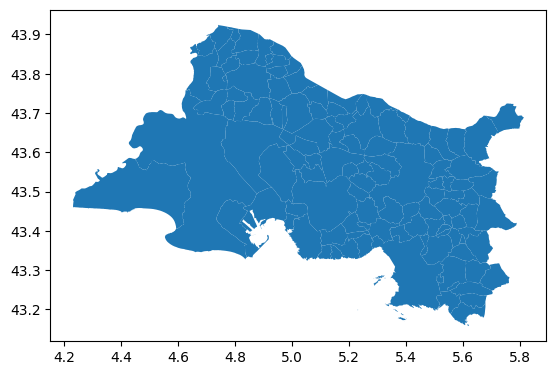

In [173]:
communes_bdr_13.plot()

Affichage par commune, par route la plus proche (chaque commune est rattachée ici à sa route la plus proche) :

In [174]:
communes_bdr_13['nearlier_road'].value_counts()

nearlier_road
355     7
346     7
308     6
312     5
5874    5
       ..
314     1
5799    1
1460    1
320     1
1496    1
Name: count, Length: 63, dtype: int64

63 tronçons...

In [175]:
communes_bdr_13_spec = copy.copy(communes_bdr_13)

In [176]:
communes_bdr_13_spec['nearlier_road'] = communes_bdr_13_spec['nearlier_road'].apply(lambda integer : str(integer))

<Axes: >

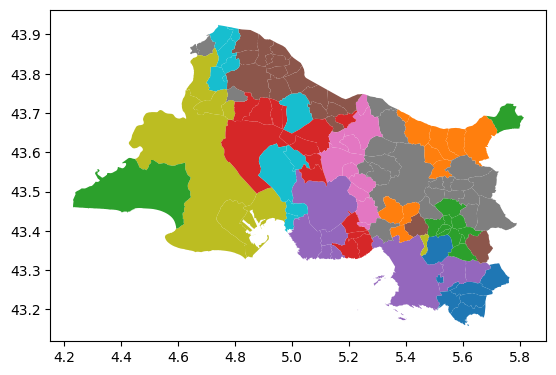

In [177]:
communes_bdr_13_spec.plot(column='nearlier_road')

In [79]:
#communes_bdr_13['traffic_vp'] = communes_bdr_13['nb_vp']*(1/1+np.log(1 + communes_bdr_13['nearlier_road_dist']/DIST_VOL_OISEAU))

/home/jesshuan/miniconda3/envs/ECartoMobile/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [178]:
communes_bdr_13[['nom', 'nb_vp','nearlier_road_dist']][0:60]

,nom,nb_vp,nearlier_road_dist
13685,Simiane-Collongue,6793.0,4195.347811
13686,Aix-en-Provence,154907.0,778.293607
13687,Le Puy-Sainte-Réparade,6797.0,5837.670260
13905,Marseille,72.0,562.020338
13933,Mollégès,2925.0,6328.022010
13934,Verquières,963.0,4613.113504
13935,Saint-Andiol,4053.0,4310.535312
13936,Noves,6415.0,3708.781125
13937,Cabannes,5461.0,1273.867938
13938,Eygalières,2667.0,9777.842082


Problème avec Marseille !...

Besoin de corriger à la main :

In [179]:
communes_bdr_13.loc[communes_bdr_13['nom']=='Marseille','nb_vp'] = 720000

Amplification du poids du nombre de véhicule de la commune selon la distance à la route (racine quatrième par exemple) :

In [180]:
communes_bdr_13['traffic_vp'] = communes_bdr_13['nb_vp']/communes_bdr_13['nearlier_road_dist']**(1/4)

In [181]:
communes_bdr_13[['nom', 'nb_vp','nearlier_road_dist','traffic_vp']][0:60]

,nom,nb_vp,nearlier_road_dist,traffic_vp
13685,Simiane-Collongue,6793.0,4195.347811,844.052813
13686,Aix-en-Provence,154907.0,778.293607,29328.184353
13687,Le Puy-Sainte-Réparade,6797.0,5837.670260,777.602020
13905,Marseille,720000.0,562.020338,147874.908330
13933,Mollégès,2925.0,6328.022010,327.950936
13934,Verquières,963.0,4613.113504,116.849740
13935,Saint-Andiol,4053.0,4310.535312,500.200132
13936,Noves,6415.0,3708.781125,822.032257
13937,Cabannes,5461.0,1273.867938,914.094456
13938,Eygalières,2667.0,9777.842082,268.202154


<Axes: >

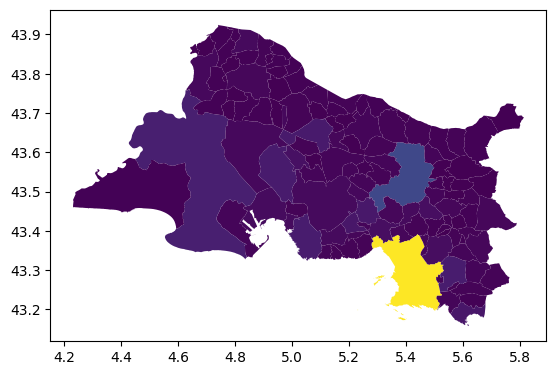

In [183]:
communes_bdr_13.plot(column='nb_vp')

<Axes: >

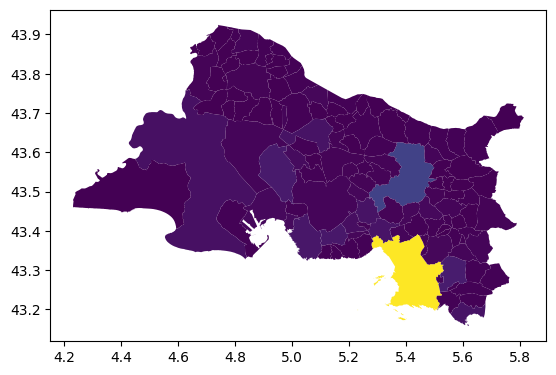

In [182]:
communes_bdr_13.plot(column='traffic_vp')

Evaluation du trafic local de la route, comme somme (pour chaque commune) des voitures immatriculées / distance de chaque commune :

In [184]:
traffic_values = communes_bdr_13.groupby('nearlier_road')['traffic_vp'].sum().to_dict()

Visualisation des 63 routes qui ont des communes rattachées :

<Axes: >

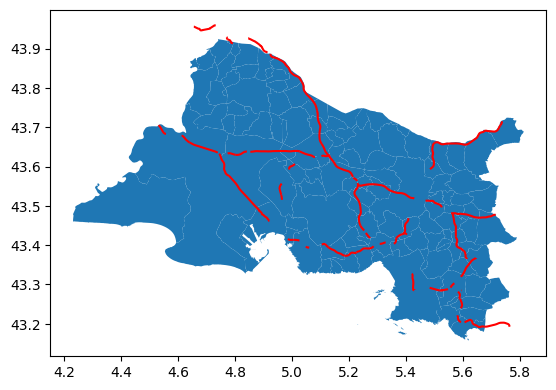

In [189]:
tmja_wrs84_13_not_null = tmja_wrs84.loc[tmja_wrs84.index.isin(traffic_values.keys()),:]

fig, ax = plt.subplots(1, 1)

communes_bdr_13.plot(ax=ax)
tmja_wrs84_13_not_null.plot(ax=ax, color='r')

Le "rabattement" du traffic supposé local sur les routes produit une discontinuité. En effet, certaines routes n'ont aucune commune rattachée à elle... [Problème à éventuellement gérer avec une extrapolation moyenne des routes dépourvues de traffic à partir des plus proches voisines]

In [190]:
tmja_wrs84_13_not_null['tjma_local'] = list(traffic_values.values())

/home/jesshuan/miniconda3/envs/ECartoMobile/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: >

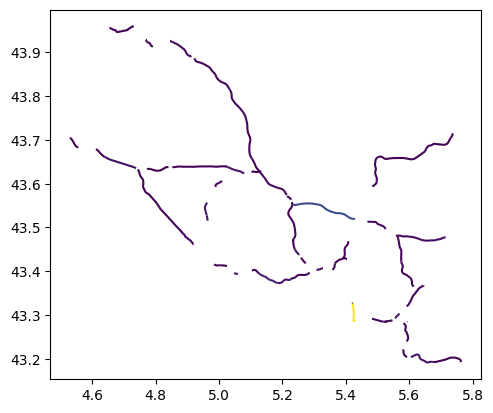

In [191]:
tmja_wrs84_13_not_null.plot(column='tjma_local')

In [192]:
tmja_wrs84_13_not_null

,dateRefere,route,longueur,prD,depPrD,concession,absD,cumulD,xD,yD,...,xF,yF,zF,cote,anneeMesur,typeCompta,tmja,pctPL,geometry,tjma_local
308,2018-01-01,A0007,12385.0,199,84,C,475.0,213839.0,854505.45,6311612.22,...,863613.14,6303922.66,0.0,I,2018,1,58834,12.90,"LINESTRING (4.92272 43.88659, 4.92281 43.88634...",2780.382327
309,2018-01-01,A0007,9330.0,211,13,C,860.0,226224.0,863613.14,6303922.66,...,868110.26,6296015.09,0.0,I,2018,1,66916,13.50,"LINESTRING (5.03354 43.81536, 5.03381 43.81502...",3102.497568
310,2018-01-01,A0007,9790.0,221,13,C,190.0,235554.0,868110.26,6296015.09,...,869693.31,6286551.61,0.0,I,2018,1,64531,13.64,"LINESTRING (5.08682 43.74317, 5.08718 43.74206...",1648.642399
311,2018-01-01,A0007,4006.0,230,13,C,980.0,245344.0,869693.31,6286551.61,...,871825.02,6283178.85,0.0,I,2018,1,62736,13.96,"LINESTRING (5.10333 43.65766, 5.10346 43.65751...",76.789761
312,2018-01-01,A0007,9391.4,234,13,C,986.0,249350.0,871825.02,6283178.85,...,878820.59,6277480.69,0.0,I,2018,1,94121,12.79,"LINESTRING (5.12861 43.62681, 5.12862 43.62681...",4822.115555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5792,2018-01-01,N0569,345.0,0,13,N,0.0,0.0,863203.62,6284562.25,...,863168.23,6284226.32,0.0,I,2018,8,0,0.00,"LINESTRING (5.02230 43.64129, 5.02234 43.64114...",949.050725
5799,2018-01-01,N0569,2440.0,3,13,N,592.0,3964.0,862256.55,6280658.42,...,860667.58,6279067.86,0.0,I,2018,1,0,0.00,"LINESTRING (5.00933 43.60640, 5.00906 43.60624...",4371.979713
5802,2018-01-01,N0569,4554.0,10,13,N,400.0,10900.0,858639.92,6275030.07,...,858847.92,6270457.14,0.0,I,2018,8,0,0.00,"MULTILINESTRING ((4.96283 43.55659, 4.96234 43...",9964.975938
5873,2018-01-01,N1007,639.0,22,84,N,0.0,0.0,842073.08,6316081.12,...,842335.63,6315506.52,0.0,I,2018,1,18703,0.00,"LINESTRING (4.76930 43.92941, 4.76938 43.92937...",601.982302


----------

In [194]:
traffic_values

{308: 2780.382327158028,
 309: 3102.4975680603075,
 310: 1648.6423988577521,
 311: 76.78976069522955,
 312: 4822.115554745075,
 314: 1358.050327597358,
 316: 1496.6546553551382,
 317: 2814.3618900955817,
 318: 7045.613361338417,
 320: 1344.0611103330732,
 327: 7554.772374926396,
 346: 34544.89892120279,
 350: 4975.121990795283,
 355: 4279.007712324104,
 1434: 2546.904391171371,
 1435: 1333.6957496166535,
 1440: 1156.6009950243463,
 1441: 837.7539847347889,
 1443: 1163.7234596639853,
 1447: 7854.443366017757,
 1448: 685.341064104285,
 1460: 1867.7989295773134,
 1461: 1459.0413553419223,
 1463: 2762.096628714599,
 1472: 2484.597217611891,
 1473: 1434.2960005470209,
 1474: 1511.4160286828264,
 1475: 197.09782049532157,
 1492: 2627.804392579995,
 1493: 2917.0378239447045,
 1494: 1827.6238954179694,
 1496: 1826.3588648552663,
 1503: 300.24973873357163,
 1505: 317.0421721965183,
 1507: 2816.6817750347172,
 1508: 9688.736012599009,
 1510: 228.19902746350445,
 1524: 3345.4894449679396,
 1525: 

In [195]:
to_keep = (tmja_wrs84_clean['xD']>=850000) & (tmja_wrs84_clean['xD']<=920000) & (tmja_wrs84_clean['yD']<=6300000) & (tmja_wrs84_clean['yD']>=6000000)

tmja_wrs84_dep13 = tmja_wrs84_clean.loc[to_keep,:]

In [200]:
tmja_wrs84_dep13['tmja_local'] = tmja_wrs84_dep13['road_index'].map(traffic_values)

/home/jesshuan/miniconda3/envs/ECartoMobile/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Extrapolation du traffic local pour les routes "orphelines" (rattachées )

In [218]:
def split_and_fill_Local_null_values_by_key(df, column_key, missing_value=0,nb_rep=10, buffer_size=0.01):

    geometry_conservation = df.geometry

    df_clean = copy.copy(df)

    try:
        df_clean.reset_index(names="road_index", inplace=True)
    except Exception as e:
        print(e)
        pass

    df_buf = df_clean.buffer(buffer_size)

    df_clean.geometry = df_buf

    total_values = 0

    for k in range(nb_rep):

        new_tmja = []
        values = 0

        tmja_list = df_clean[column_key].to_list()
        index_list = df_clean['road_index'].to_list()

        df_join_road = df_clean.sjoin(df_clean, how='inner')
        df_join_road_clean = df_join_road.loc[df_join_road['road_index_left']!=df_join_road['road_index_right'],:]
        dict_new = df_join_road_clean[['road_index_left',f'{column_key}_right']].groupby('road_index_left').mean().to_dict()[f'{column_key}_right']

        for i, index in enumerate(index_list):
            old_tmja = tmja_list[i]
            if old_tmja == missing_value or str(old_tmja)==missing_value:
                try:
                    new_tmja.append(dict_new[index])
                    values+=1
                except:
                    new_tmja.append(old_tmja)
            else:
                new_tmja.append(old_tmja)
        
        df_clean[column_key] = new_tmja
    
        total_values += values

        print(f'... {k+1} rounds done. {values} are been modified... Total values modified : {total_values}')
    
    df_clean.geometry = geometry_conservation

    return df_clean

In [217]:
tmja_wrs84_dep13_clean['tmja_local'].to_list()[3] == float('nan')

False

In [219]:
tmja_wrs84_dep13_clean = split_and_fill_Local_null_values_by_key(tmja_wrs84_dep13, 'tmja_local', missing_value='nan', nb_rep=15, buffer_size=0.01)

cannot insert road_index, already exists
... 1 rounds done. 112 are been modified... Total values modified : 112


/tmp/ipykernel_8881/3478329717.py:13: UserWarning:

Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




... 2 rounds done. 20 are been modified... Total values modified : 132
... 3 rounds done. 2 are been modified... Total values modified : 134
... 4 rounds done. 0 are been modified... Total values modified : 134
... 5 rounds done. 0 are been modified... Total values modified : 134
... 6 rounds done. 0 are been modified... Total values modified : 134
... 7 rounds done. 0 are been modified... Total values modified : 134
... 8 rounds done. 0 are been modified... Total values modified : 134
... 9 rounds done. 0 are been modified... Total values modified : 134
... 10 rounds done. 0 are been modified... Total values modified : 134
... 11 rounds done. 0 are been modified... Total values modified : 134
... 12 rounds done. 0 are been modified... Total values modified : 134
... 13 rounds done. 0 are been modified... Total values modified : 134
... 14 rounds done. 0 are been modified... Total values modified : 134
... 15 rounds done. 0 are been modified... Total values modified : 134


<Axes: >

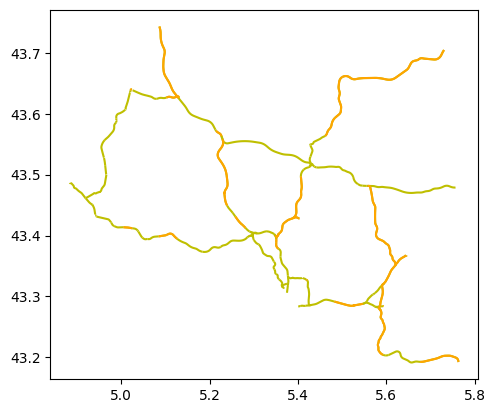

In [223]:
fig, ax = plt.subplots(1, 1)

tmja_wrs84_dep13_clean.loc[tmja_wrs84_dep13_clean['tmja_local']>0,:].plot(ax=ax, color='y')
tmja_wrs84_dep13_clean.loc[(tmja_wrs84_dep13_clean['tmja_local']>0) & (tmja_wrs84_dep13_clean['tmja_local']<3000),:].plot(ax=ax, color='orange')
#tmja_wrs84_dep13_clean.loc[tmja_wrs84_dep13_clean['tmja_local']==0,:].plot(ax=ax, color='r')

Problème de discontinuité résolue

-------

In [231]:
tmja_wrs84_dep13_clean['tmja_tourist'] = tmja_wrs84_dep13_clean['tmja'] - 0.001 * tmja_wrs84_dep13_clean['tmja_local']

In [232]:
min(tmja_wrs84_dep13_clean['tmja_tourist'])

-31.994020769768817

In [233]:
max(tmja_wrs84_dep13_clean['tmja_tourist'])

123287.65593888967

<Axes: >

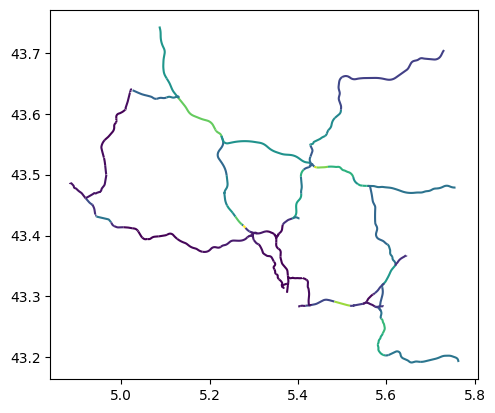

In [234]:
tmja_wrs84_dep13_clean.plot(column='tmja_tourist')

<Axes: >

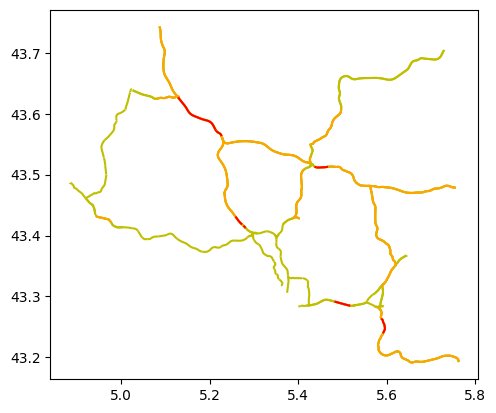

In [236]:
fig, ax = plt.subplots(1, 1)

tmja_wrs84_dep13_clean.loc[tmja_wrs84_dep13_clean['tmja_tourist']>0,:].plot(ax=ax, color='y')
tmja_wrs84_dep13_clean.loc[tmja_wrs84_dep13_clean['tmja_tourist']>10000,:].plot(ax=ax, color='y')
tmja_wrs84_dep13_clean.loc[tmja_wrs84_dep13_clean['tmja_tourist']>40000,:].plot(ax=ax, color='orange')
tmja_wrs84_dep13_clean.loc[tmja_wrs84_dep13_clean['tmja_tourist']>80000,:].plot(ax=ax, color='r')